In [8]:

import numpy as np
import segyio
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.signal import butter, lfilter
from ipywidgets import Button, HBox, VBox

import matplotlib
import warnings
warnings.filterwarnings('ignore')
from scipy.signal.signaltools import hilbert
import glob
import cmath
from mpl_toolkits.mplot3d import Axes3D
from skimage.transform import rescale 
from mayavi import mlab
#from scipy import ndimage
from skimage.filters import sobel

#plt.rcParams["figure.figsize"] = (10,5)

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

#%matplotlib inline
%matplotlib notebook
sourcefile='D:/small.sgy'
sourcefile='D:/Vawn.SGY'
sourcefile="C:/Users/koushb/OneDrive - Husky Energy/ML/ML_S_Int/For GoogleML data/data/Cropped SGY/DV.sgy"




filter_files=['None']


for file in glob.glob(".\\filters\\*.npz"):
    filter_files.append(file)

 




def do_filter(x):
    file_name=filters.value
    
    data = np.load(file_name, fix_imports=True, encoding='bytes') # array containing dict, dtype 'object'    
    b,a=data['ba']
    for i in range(x.shape[-1]):    
        x[...,i]= lfilter(b, a, x[...,i])
    return(x)


 

In [9]:
src=segyio.open(sourcefile)


vol=[]
for inline in src.ilines:
    vol.append(np.array(src.iline[inline]).T)
vol=np.array(vol)
vol=np.swapaxes(vol,0,1)
vol=np.swapaxes(vol,0,2)

volumes=[vol]

ilines=src.ilines
xlines=src.xlines
TimeSamples=src.samples

src.close()

#np_s=readsegy(sourcefile)

il_min=ilines[0]
il_max=ilines[-1]

xl_min=xlines[0]
xl_max=xlines[-1]


z_min=TimeSamples[0]
z_max=TimeSamples[-1]

In [52]:
# from https://github.com/geopyteam/cognitivegeo/blob/master/cognitivegeo/src/seismic/attribute.py

def calcEdge_detection(x):
    x=  sobel(x)
    
#    i=att_par.value
#    #['Scipy Sobel','Skimage Sobel','Skimage Roberts','Skimage scharr','Skimage prewitt']
#    if i=='Scipy Sobel':        
#        x = ndimage.sobel(x)
#    elif i=='Skimage Sobel':
#        x=  sobel(x)
#    elif i=='Skimage Roberts':
#        x=  roberts(x)
#    elif i=='Skimage scharr':
#        x=  scharr(x)
#    elif i=='Skimage prewitt':
#        x=  prewitt(x)
#    else:
#        pass
#from skimage.filters import roberts, sobel, sobel_h, sobel_v, scharr, \
#    scharr_h, scharr_v, prewitt, prewitt_v, prewitt_h, farid_v, farid_h

    return(x)

def calcPhaseShift_trace(x,d):
    #from https://stackoverflow.com/questions/52179919/amplitude-and-phase-spectrum-shifting-the-phase-leaving-amplitude-untouched
    
    phase=d*(np.pi/180)
    signalFFT = np.fft.rfft(x)
    

    ## Get Power Spectral Density
    signalPSD = np.abs(signalFFT) ** 2
    signalPSD /= len(signalFFT)**2

    ## Get Phase
    signalPhase = np.angle(signalFFT)

    ## Phase Shift the signal +90 degrees
    newSignalFFT = signalFFT * cmath.rect( 1., phase )

    ## Reverse Fourier transform
    newSignal = np.fft.irfft(newSignalFFT,x.shape[0])
    return newSignal
def calcPhaseShift(x):
    d=att_par.value
    #print(d)
    attrib = x.copy()
    for i in range(x.shape[-1]):    
            attrib[...,i]= calcPhaseShift_trace(x[...,i],d)
    return (attrib)

def calcFirstDerivative_trace(y): #x:time sample y: trace
    x=TimeSamples
    dy = np.zeros(y.shape,np.float)
    dy[0:-1] = np.diff(y)/np.diff(x)
    dy[-1] = (y[-1] - y[-2])/(x[-1] - x[-2])
    return(dy)




def calcCumulativeSum(x):
    """
    Calculate cusum attribute
    Args:
        x: seismic data in 3D matrix [Z/XL/IL]
    Return:
        cusum attribute as 3D matrix
    """
    return np.cumsum(x, axis=0)

def calcFirstDerivative(x):
    """
    Calculate first derivative attribute
    Args:
        x: seismic data in 3D matrix [Z/XL/IL]
    Return:
        first-derivative attribute as 3D matrix
    """
    attrib = x.copy()
    for i in range(x.shape[-1]):    
        attrib[...,i]= calcFirstDerivative_trace(x[...,i])
    return attrib

def calcInstanEnvelop(x):
    """
    Calculate instantaneous envelop attribute
    Args:
        x: seismic data in 3D matrix [Z/XL/IL]
    Return:
        Instantaneous envelop attribute as 3D matrix
    """

    attrib = np.abs(hilbert(x, axis=0))

    return attrib

def calcInstanQuadrature(x):
    """
    Calculate instantaneous quadrature attribute
    Args:
        x: seismic data in 3D matrix [Z/XL/IL]
    Return:
        Instantaneous quadrature attribute as 3D matrix
    """

    attrib = np.imag(hilbert(x, axis=0))
    return attrib

def calcInstanPhase(x):
    """
    Calculate instantaneous phase attribute
    Args:
        x: seismic data in 3D matrix [Z/XL/IL]
    Return:
        Instantaneous phase attribute as 3D matrix
    """

    attrib = np.angle(hilbert(x, axis=0))
    attrib = attrib * 180.0 / np.pi
    #
    return attrib

def calcInstanFrequency(x):
    """
    Calculate instantaneous frequency attribute
    Args:
        x: seismic data in 3D matrix [Z/XL/IL]
    Return:
        Instantaneous frequency attribute as 3D matrix
    """

    instphase = np.unwrap(np.angle(hilbert(x, axis=0)), axis=0) * 0.5 / np.pi
    attrib = np.zeros(np.shape(x))
    attrib[1:-1, ...] = 0.5 * (instphase[2:,...] - instphase[0:-2,...])
    return attrib

def calcInstanCosPhase(x):
    """
    Calculate instantaneous cosine of phase attribute
    Args:
        x: seismic data in 3D matrix [Z/XL/IL]
    Return:
        Cosine of phase attribute as 3D matrix
    """

    attrib = np.angle(hilbert(x, axis=0))
    attrib = np.cos(attrib)
    #
    return attrib

def calc_att(x):
    att=attribute.value
    y=x.copy()
    if att=='Phase Shift':
        #print('Phase')
        y=calcPhaseShift(x)
    elif att=='Edge Detection':
        y=calcEdge_detection(x)
    elif att=='CumulativeSum':
        y=calcCumulativeSum(x)
    elif att=='FirstDerivative':
        y=calcFirstDerivative(x)
    elif att=='InstanEnvelop':
        y=calcInstanEnvelop(x)
    elif att=='InstanQuadrature':
        y=calcInstanQuadrature(x)
    elif att=='InstanPhase':
        y=calcInstanPhase(x)
    elif att=='InstanFrequency':
        y=calcInstanFrequency(x)
    elif att=='InstanCosPhase':
        y=calcInstanCosPhase(x)
    return(y)

In [53]:

def il_plot(clear=False):
    #tt=np.array(src.iline[inline]).T
    global volumes
    inline_ind=il_Slider.index
    cmap=colormap.value
    interp_method=interpolation.value
    print(select_realize.index)
    vol=volumes[select_realize.index]
    t=vol[:,inline_ind,:].T
    print(inline,inline_ind)
    #print(t.shape,tt.shape)
    #print(np.sum((t-tt)**2))
    #t=tt.copy()
    
    s=resizefactor.value
    if s>1:
        t=rescale(t, 1/s, anti_aliasing=False)
        
        
    if filters.value != 'None':
        t=do_filter(t)


    if attribute.value != "None":
        t=calc_att(t)

    
    if auto_scale.value:
        vmin.value=t.min()
        vmax.value=t.max()    
    if clear:
        plt.clf()

    plt.imshow(t,cmap=cmap,interpolation=interp_method,vmin=vmin.value,vmax=vmax.value,extent=[xl_min,xl_max,z_max,z_min])
    plt.axes().set_aspect(1/vert_ex.value)
    plt.title('in line: '+str(il_Slider.value))

    if clear:

        plt.colorbar()
    
    
    
def xl_plot(clear=False):
    global volumes
    xline_ind=xl_Slider.index    
    cmap=colormap.value
    interp_method=interpolation.value
    vol=volumes[select_realize.index]
    t=vol[xline_ind,:,:].T
    
    #xline=xl_Slider.value
    #tt=np.array(src.xline[xline]).T
    #tt=vol[:,inline_ind,:].T
    #print(np.sum((t-tt)**2))
    
    s=resizefactor.value
    if s>1:
        t=rescale(t, 1/s, anti_aliasing=False)
    
    if filters.value != "None":
        t=do_filter(t)

    if attribute.value != "None":
        t=calc_att(t)

    
    if auto_scale.value:
        vmin.value=t.min()
        vmax.value=t.max()

    if clear:
        plt.clf()
    plt.imshow(t,cmap=cmap,interpolation=interp_method,vmin=vmin.value,vmax=vmax.value,extent=[il_min,il_max,z_max,z_min])
    plt.axes().set_aspect(1/vert_ex.value)
    plt.title('cross line: '+str(xl_Slider.value))
    if clear:
        plt.colorbar()
    #plt.show()

    
    
def z_plot(clear=False):
    global volumes
    z_ind=z_Slider.index    
    cmap=colormap.value
    interp_method=interpolation.value
    vol=volumes[select_realize.index]
    t=vol[:,:,z_ind].T
    
    #z=z_Slider.value
    #print(z)
    #tt=np.array(src.depth_slice[z_ind])
    #print(np.sum((t-tt)**2))
    
    s=resizefactor.value
    if s>1:
        t=rescale(t, 1/s, anti_aliasing=False)
    
    if filters.value != 'None':
        t=do_filter(t)
        
    if auto_scale.value:
        vmin.value=t.min()
        vmax.value=t.max()

    if attribute.value != "None":
        t=calc_att(t)

    
    #plt.figure('Time Slice')
    
    if clear:
        plt.clf()
    plt.imshow(t,cmap=cmap,interpolation=interp_method,vmin=vmin.value,vmax=vmax.value,extent=[xl_min,xl_max,il_min,il_max])
    plt.axes().set_aspect(1)
    plt.title('Time Slice: '+str(z_Slider.value))
    if clear:
        plt.colorbar()

def t_plot():
    global volumes
    inline_ind=il_Slider.index
    xline_ind=xl_Slider.index    
    cmap=colormap.value
    interp_method=interpolation.value
    vol=volumes[select_realize.index]
    #t=vol[xline_ind,:,:].T
    
    #print(inline,xline)

    
    trace=vol[inline_ind,xline_ind,:]
    
    #s=resizefactor.value
    #if s>1:
    #    trace=rescale(trace, 1/s, anti_aliasing=False)
    
    if filters.value != 'None':
        trace=do_filter(trace)


    if attribute.value != "None":
        trace=calc_att(trace)
        
    
    if auto_scale.value:
        vmin.value=trace.min()
        vmax.value=trace.max()

    
    plt.clf()
    plt.plot(trace,TimeSamples)    
    plt.xlim(vmin.value,vmax.value)
    plt.ylim(TimeSamples[-1],TimeSamples[0])
    plt.axes().set_aspect('auto')     
    plt.title('in line: '+str(il_Slider.value)+', x line: '+str(xl_Slider.value))


def plot_3D(inline,xline,z,cmap,interp_method,clear=False):
    global volumes
    
    s=resizefactor.value
    #inline_ind=inline-il_min
    #xline_ind=xline-xl_min
    inline_ind=il_Slider.index
    xline_ind=xl_Slider.index  
    z_ind=z_Slider.index   
    
    
    
    #z_ind=z-z_min
    vol=volumes[select_realize.index]
    grid = mlab.pipeline.scalar_field(vol)
    grid.spacing = [1, 1.0, 1/s]

    mlab.pipeline.image_plane_widget(grid,
                                plane_orientation='x_axes',
                                slice_index=inline_ind,
                                colormap=cmap
                            )
    mlab.pipeline.image_plane_widget(grid,
                                plane_orientation='y_axes',
                                slice_index=xline_ind,
                                colormap=cmap
                            )
    mlab.pipeline.image_plane_widget(grid,
                                plane_orientation='z_axes',
                                slice_index=z_ind,
                                colormap=cmap
                            )
    mlab.outline()
    mlab.show()

    
    
 
#https://gis.stackexchange.com/questions/200180/convert-and-plot-python-basemap-and-netcdf-file-in-utm-zone-45n/201155

In [54]:
select_realize=widgets.Dropdown(
    options=['original'],
    value='original',
    description='Select Seismic Volume',
    disabled=False,
    style={'description_width': 'initial'}
)

realizeit = widgets.Button(description="Realize")
realizename=widgets.Text(
    value='Realize 1',
    placeholder='Type something',
    description='String:',
    disabled=False
)


#itrace=widgets.Checkbox(value=False,description='Plot Trace',disabled=False,indent=False)
c_update=widgets.Checkbox(value=False,description='Continuous Update',disabled=False,indent=False)
auto_scale=widgets.Checkbox(value=False,description='Auto Color Scale',disabled=False,indent=False)

il_Slider= widgets.SelectionSlider(options=ilines,description='Inline',continuous_update=False)
xl_Slider= widgets.SelectionSlider(options=xlines,description='Xline',continuous_update=False)
z_Slider = widgets.SelectionSlider(options=TimeSamples,description='Zline',continuous_update=False)

resizefactor=widgets.IntSlider(min=1, max=100, value=1, description='Resize Fac.',continuous_update=False)
vmin     = widgets.IntSlider(min=-40000, max=40000, value=-40000, description='Amp. Min',continuous_update=False)
vmax     = widgets.IntSlider(min=-40000, max=40000, value=40000, description='Amp. Max',continuous_update=False)
vert_ex  = widgets.IntSlider(min=1, max=100, value=10, description='Ver. Exag.',continuous_update=False)
att_par  = widgets.SelectionSlider(options=range(360), value=0, description='Att. Par.',continuous_update=False,disabled=True)

colormap=widgets.Dropdown(
    options=['seismic','viridis', 'plasma', 'inferno', 'magma', 'cividis','Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn','binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink','spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia','hot', 'afmhot', 'gist_heat', 'copper','PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu','RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'twilight', 'twilight_shifted', 'hsv','Pastel1', 'Pastel2', 'Paired', 'Accent','Dark2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c','flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern','gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg','gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'
            ],
    value='seismic',
    description='Colormap',
    disabled=False,
)



interpolation=widgets.Dropdown(
    options=['nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos'],
    value='nearest',
    description='Interpolation',
    disabled=False,
)


attribute=widgets.Dropdown(
    options=['None', 'Phase Shift', 'Edge Detection', 
           'CumulativeSum', 'FirstDerivative', 'InstanEnvelop', 'InstanQuadrature', 'InstanPhase', 'InstanFrequency',
           'InstanCosPhase'],
    value='None',
    description='Attributes',
    disabled=False,
)




filters=widgets.Dropdown(
    options=filter_files,
    value='None',
    description='Filters',
    disabled=False,
)


graphtype=widgets.RadioButtons(
    options=['1D', '2D', '3D'],
#    value='pineapple', # Defaults to 'pineapple'
#    layout={'width': 'max-content'}, # If the items' names are long
    description='Type',
    value='2D',
    disabled=False
)


In [55]:

t=0

def plotem(clear=False):
    if graphtype.value=='1D':
        t_plot()
    elif graphtype.value=='2D':        
        if t==1:
            il_plot(clear=clear)
        elif t==2:
            xl_plot(clear=clear) 
        else:
            z_plot(clear=clear)
    else:
        #print('3D')
        plot_3D(il_Slider.value,xl_Slider.value,z_Slider.index,colormap.value,interpolation.value,clear=True)
        

#il_Slider= widgets.IntSlider(min=il_min,max=il_max,description='Inline')
def on_value_change(change):  
    global t
    #print(t,change)
    #return()
    #print(change['owner'].description)
    if change['owner'].description=='Type':
       # print(graphtype.value,t)
        if graphtype.value=='1D':
            t_plot()
            t=0
        elif graphtype.value=='2D':
            il_plot(clear=True)
            t=1
        else:
            #print('3D')
            plot_3D(il_Slider.value,xl_Slider.value,z_Slider.index,colormap.value,interpolation.value,clear=True)
            
#    if itrace.value:
#        t_plot(il_Slider.value,xl_Slider.value)
#        t=0
#    elif change['owner'].description=='Plot Trace':         #this is when we uncheck trace            
#        il_plot(il_Slider.value,colormap.value,interpolation.value,clear=True)
        #print('what?')
    elif change['owner'].description=='Inline':
        if t==1:
            c=False
        else:
            c=True
        
        #il_plot(change['owner'].value,colormap.value,interpolation.value,clear=c)
        t=1
        plotem(c)
    elif change['owner'].description=='Xline':
        if t==2:
            c=False
        else:
            c=True
        
        #xl_plot(change['owner'].value,colormap.value,interpolation.value,clear=c)
        t=2
        plotem(c)
    elif change['owner'].description=='Zline':
        if t==3:
            c=False
        else:
            c=True
        
        #z_plot(change['owner'].index,colormap.value,interpolation.value,clear=c)
        t=3
        plotem(c)
    if change['owner'].description=='Colormap' or change['owner'].description=='Amp. Min'or \
    change['owner'].description=='Amp. Max' or change['owner'].description=='Att. Par.' or \
    change['owner'].description=='Resize Fac.' or change['owner'].description=='Select Seismic Volume':
        #print(change['owner'].description)
        if t==1:
            il_plot(clear=True)
        elif t==2:
            xl_plot(clear=True)
        elif t==3:
            z_plot(z_Slider.index,colormap.value,interpolation.value,clear=True)
    elif  change['owner'].description=='Interpolation':
        if t==1:
            il_plot()
        elif t==2:
            xl_plot()
        elif t==3:
            z_plot()
    elif  change['owner'].description=='Filters'or change['owner'].description=='Ver. Exag.':
        #print(change['owner'].description)
        if t==0:
            t_plot()
        if t==1:
            il_plot()
        elif t==2:
            xl_plot()
        elif t==3:
            z_plot()    
            
    elif change['owner'].description=='Continuous Update':       
        il_Slider.continuous_update=c_update.value
        xl_Slider.continuous_update=c_update.value
        z_Slider.continuous_update=c_update.value
        vmin.continuous_update=c_update.value
        vmax.continuous_update=c_update.value
        vert_ex.continuous_update=c_update.value
        att_par.continuous_update=c_update.value
    elif  change['owner'].description=='Attributes':     
        #print(attribute.value)
        if attribute.value=='Phase Shift':
            #print('Enable  degree')
            att_par.disabled = False
            att_par.options=range(360)
            #att_par.max=360
            att_par.observe(on_value_change,names=['value'])
            
#        elif attribute.value=='Edge Detection':
#            att_par.disabled = False
#            att_par.options=['Scipy Sobel','Skimage Sobel','Skimage Roberts','Skimage scharr','Skimage prewitt']
#            att_par.min=1
#            att_par.max=13
#            att_par.observe(on_value_change,names=['value'])
        else:
            #print('disable degree')
            att_par.disabled = True
            att_par.unobserve_all()
            
        
        if t==0:
            t_plot()
        if t==1:
            il_plot()
        elif t==2:
            xl_plot()
        elif t==3:
            z_plot()    

        
        
    else:    
        print('none: ',change['owner'].description)

def auto_scale_value_change(change):
    
    if auto_scale.value:
        vmin.disabled=True
        vmax.disabled=True
        vmin.unobserve_all()
        vmax.unobserve_all()
    else:
        
        vmin.disabled=False
        vmax.disabled=False
        vmin.observe(on_value_change,names=['value'])
        vmax.observe(on_value_change,names=['value'])

def on_realizeit(change):
    print('realize')
    global volumes
    select_realize.options = (*select_realize.options, realizename.value)
    #select_realize.options=select_realize.options+(realizename.value)
    vol=volumes[select_realize.index]
    
    if filters.value != 'None':
        vol=do_filter(vol)
        

    if attribute.value != "None":
        vol=calc_att(vol)
        


    volumes.append(vol)
        
#graphtype.observe(on_value_change,names=['value'])    
#itrace.observe(on_value_change,names=['value'])
il_Slider.observe(on_value_change, names='value')
xl_Slider.observe(on_value_change, names='value')
z_Slider.observe(on_value_change, names='value')
vmin.observe(on_value_change,names=['value'])
vmax.observe(on_value_change,names=['value'])
colormap.observe(on_value_change,names=['value'])
interpolation.observe(on_value_change,names=['value'])
vert_ex.observe(on_value_change,names=['value'])
c_update.observe(on_value_change,names=['value'])
filters.observe(on_value_change,names=['value'])
attribute.observe(on_value_change,names=['value'])
auto_scale.observe(auto_scale_value_change,names=['value'])
att_par.observe(on_value_change,names=['value'])
resizefactor.observe(on_value_change,names=['value'])
select_realize.observe(on_value_change,names=['value'])
realizeit.on_click(on_realizeit)


#iBP=widgets.Checkbox(value=False,description='band pass',disabled=False)
#LB= widgets.IntSlider(min=1, max=200, value=0, description='low band')
#HB= widgets.IntSlider(min=1, max=200, value=200, description='high band')

#iBP.observe(on_value_change,names=['value'])
#LB.observe(on_value_change,names=['value'])
#HB.observe(on_value_change,names=['value'])



Dropdown(description='Select Seismic Volume', options=('original',), style=DescriptionStyle(description_width=…

0
400 0


<IPython.core.display.Javascript object>


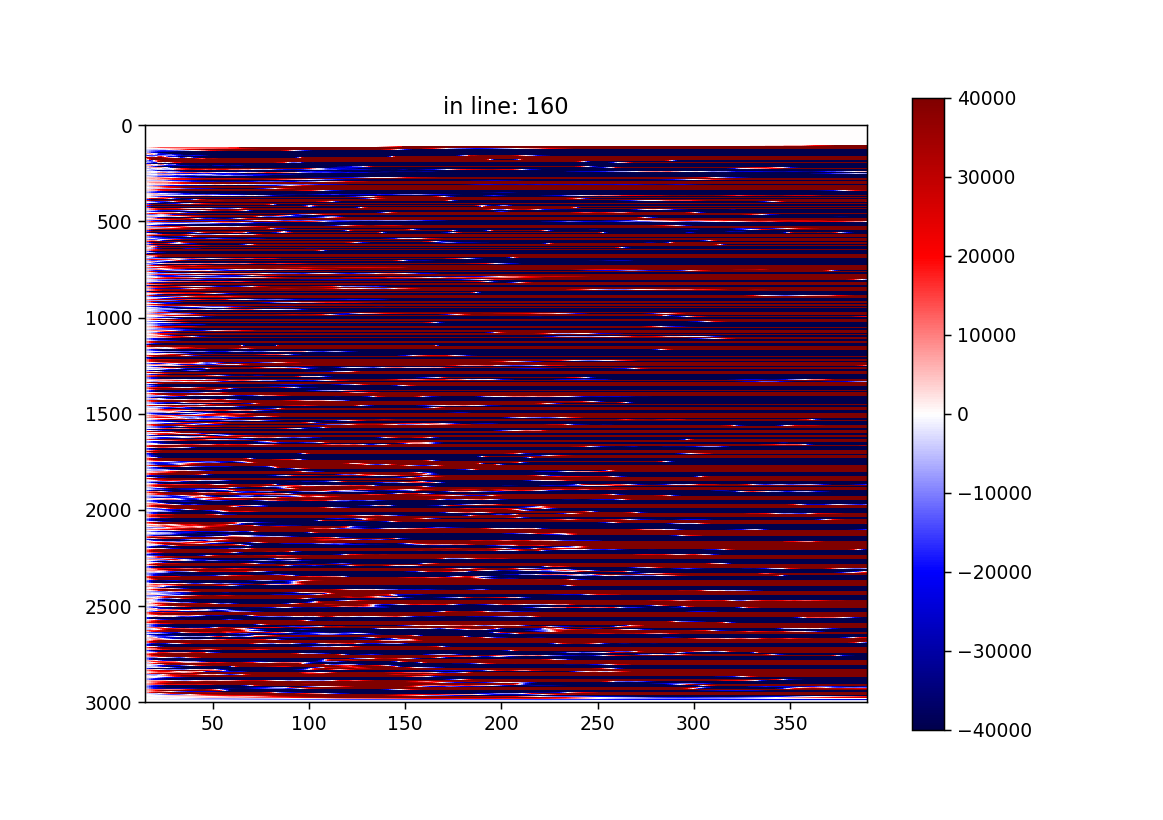

0
400 0
realize
0
400 0
1
400 0
1
400 0
1
400 0


In [56]:

v1=VBox([c_update,auto_scale])#itrace,
h1=HBox([graphtype,v1,resizefactor])#

#h1 = HBox([itrace,c_update,auto_scale])
h2= HBox([il_Slider,xl_Slider,z_Slider])
h3 = HBox([colormap,interpolation,filters])
h4= HBox([vmin,vmax,vert_ex])
h5= HBox([attribute,att_par])
h6= HBox([realizeit,realizename])
display(select_realize,h1,h2,h3,h4,h5,h6)

#right_box = VBox([items[2], items[3]])
#HBox([left_box, right_box])

#display(itrace,il_Slider,xl_Slider,z_Slider,colormap,interpolation,vmin,vmax,filters)#iBP,LB,HB,
il_plot(clear=True)
t=1
#display(xl_Slider,colormap,interpolation)
#xl_plot(src.xlines[0],colormap.value,interpolation.value,changecmap=True)
#display(z_Slider,colormap,interpolation)
#z_plot(0,colormap.value,interpolation.value,changecmap=True)